# Classification Using Quantum Support Vector Machine

First we need to get a hold of the python script that parses and loads the datasets (datasets.py) for us. This file is provided by Qiskit tutorials [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/advanced/aqua/artificial_intelligence/datasets.py).  

Generally for a support vector machine, the steps are as follows: 
Obtain the feature map by applying some non-linear transformation function to the data (classical). Then compute the kernals (quantum). The kernals are computed by using the inner product of each pair of data points in the new feature space (feature map). 

Due to the complexity of some datasets, computing the kernal is often not efficient, thus we will attemp to do this using quantum computing techniques instead.

In [1]:
# import the neccessary modules
from scripts.datasets import *
%matplotlib inline 

from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion


### Using a fictional ad hoc data set

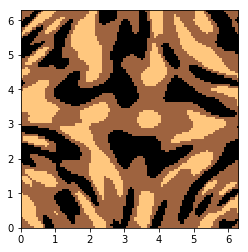

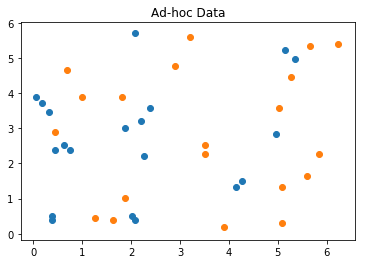

{'A': 0, 'B': 1}


In [2]:
feature_dim = 2 # at the time of writing, only 2 or 3 feature dimensions are supports.

sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size = 20,
    test_size = 10,
    n = feature_dim,
    gap = 0.3,
    PLOT_DATA = True
)

extra_test_data = sample_ad_hoc_data(sample_Total, 10, n = feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)

print(class_to_label)

As we can see, the data above is rather complex. Before we can use the qsvm algorithm, we need to initialize the parameters (dictionary) and the object containing the datasets information. 

In [3]:
"""declarative approach
params = {
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM'
    },
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}
algo_input = ClassificationInput(training_input, test_input, datapoints[0])
result = run_algorithm(params, algo_input)
"""

seed = 50594

feature_map = SecondOrderExpansion(feature_dimension = feature_dim,
                                  depth = 2,
                                  entanglement = 'linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])
backend = BasicAer.get_backend ('qasm_simulator')
quantum_instance = QuantumInstance (backend, shots = 1024, seed = seed, seed_transpiler = seed)

qsvm_results = qsvm.run(quantum_instance)

In [4]:
# lets see how we did!
print(f"Testing accurary (0-1) = {qsvm_results['testing_accuracy']}")
print(f"expected outputs : {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}") 
print(f"prediction: {qsvm_results['predicted_classes']}")      

Testing accurary (0-1) = 1.0
expected outputs : ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
prediction: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


Training Kernal Matrix


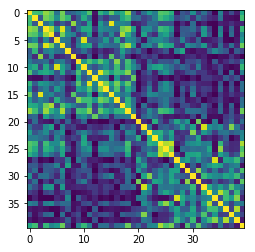

There were a total of  {'alphas': array([1.63044157, 1.03130363, 3.39594978, 3.17025294, 1.17642605,
       0.05739739, 0.30518301, 1.30908257, 1.93590194, 0.22360655,
       3.67825605, 6.23837856]), 'bias': array([0.09172638]), 'support_vectors': array([[2.26194671, 2.19911486],
       [0.75398224, 2.38761042],
       [4.27256601, 1.50796447],
       [0.62831853, 2.51327412],
       [0.43982297, 2.38761042],
       [0.31415927, 3.45575192],
       [1.88495559, 3.01592895],
       [2.38761042, 3.58141563],
       [3.51858377, 2.51327412],
       [5.65486678, 5.34070751],
       [0.43982297, 2.89026524],
       [5.84336234, 2.26194671]]), 'yin': array([-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.])}  support vectors


In [5]:
# let's see what the kernal matrix looks like
print("Training Kernal Matrix")
kernel_matrix = qsvm_results ['kernel_matrix_training']
kernels_mat_plot = plt.imshow(np.asmatrix(kernel_matrix))
plt.show()
print("There were a total of ", qsvm_results['svm'], " support vectors")

## Retrieving the Quantum Circuits
This part is research with Professor Samah Saeed of CCNY. 

The goal is to retrieve the quantum circuits used. Looking into the QSVM source code, we can see that there is a built-in method that builds the circuits from the dataset. The real challenge is understanding how to call the method and how to read (and modify) the quantum circuits.

Starting with the ad_hoc data created by Qiskit

### Understanding the dataset

The training_data is a dictionary with two keys. These keys represent the labels. Each key corresponds to a `Numpy array` of size `(20,2)`. Each element row in the arrays are a datapoint. The shape of the training set is shown:
![training_data](.\image_src\ad_hoc_training_data.png)

The `Numpy array` for key `'A'` is as follows:
![training_data_class_A](.\image_src\ad_hoc_training_data_class_A.png)

We know that the feature map uses linear entanglement. We also know that the input to the `construct_circuit` method of `qsvm` is two Numpy arrays of the size (Nx1) where N is the size of the training set, i.e. it is a column vector.

There is much to learn about the `feature_map` and the corresponding quantum circuit. [Here is a paper about feature maps in qsvms.](https://arxiv.org/pdf/1804.11326.pdf) 

In [6]:
# parsing the input training data
# we're going to remove the key from the 
A_training_data = training_input.get('A')
B_training_data = training_input.get('B')
num_circuits = 4 # number of desired circuits

There should be N^2 circuits, where N is the size of the dataset. As such, I need every combination of A and B. 
Since this would bring a total of 400 circuits, we will write some functions to help reduce the number of circuits we construct and display. 

These functions are found in /scripts/QC_helper.py

In [7]:
from scripts.QC_helper import *


In [8]:
data_for_qc = prepare_data_set_for_qc(num_circuits,
                                      A_training_data, 
                                      B_training_data)
draw_circuits(qsvm, data_for_qc)

Circuit for: x(0) transpose * x(0)
circuit info:
	circuit depth =  20 	circuit width =  4
Circuit operation breakdown:
	 {'u2': 8, 'u1': 12, 'cx': 8}
        ┌──────────┐┌────────────┐                        ┌──────────┐»
q_0: |0>┤ U2(0,pi) ├┤ U1(4.5239) ├──■──────────────────■──┤ U2(0,pi) ├»
        ├──────────┤├────────────┤┌─┴─┐┌────────────┐┌─┴─┐├──────────┤»
q_1: |0>┤ U2(0,pi) ├┤ U1(4.3982) ├┤ X ├┤ U1(1.6581) ├┤ X ├┤ U2(0,pi) ├»
        └──────────┘└────────────┘└───┘└────────────┘└───┘└──────────┘»
 c_0: 0 ══════════════════════════════════════════════════════════════»
                                                                      »
 c_1: 0 ══════════════════════════════════════════════════════════════»
                                                                      »
«     ┌────────────┐                                                 »
«q_0: ┤ U1(4.5239) ├──■──────────────────■────■───────────────────■──»
«     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌─┴─┐┌──────────

# Discussion of results
It seems like each data pair only has a different phase shift (using the u1 gate).
note that `u2(0,pi)` = `u2(-2pi, pi)` = `H gate`. This is proven and discussed in `/notes/unitary gates.pdf`